In [1]:
import sys
sys.path.append('..')

import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from operator import itemgetter
import os
import graph_tool as gt

import MuxVizPy as mxp

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

from torchsummary import summary

import torchbearer
from torchbearer import Trial, metrics, Metric
from torchbearer.callbacks import Best, ModelCheckpoint

import optuna
from optuna.samplers import TPESampler, RandomSampler

import ipywidgets
from tqdm import tqdm

import gseapy as gp

In [2]:
class RandomNetworksDataset(Dataset):
    """Apples Dataset"""

    def __init__(self, D_len=6000, rand_seed=1234):
        """
        Args:
        """
        self.rand_seed = rand_seed
        np.random.seed(rand_seed)
        #human PPI edges
        self.human_ppi = pd.read_csv("../Data/data_STRING/coexpr.edges", sep=" ")
        #human PPI connections with respective identificative index
        self.human_nodes = pd.read_csv("../Data/data_STRING/coexpr.nodes", sep=" ")
        
        self.human_g = gt.Graph(directed=False)
        self.human_g.add_edge_list(self.human_ppi.values)
        
        self.samp_len = abs(np.random.normal(30,10,D_len).astype(int))+1
        self.dir_targ_prot = [np.random.choice(self.human_nodes["ID"], N, replace=False) for N in self.samp_len]
        
    def __len__(self):
        return len(self.samp_len)

    def __getitem__(self, idx):
        # find all the first nearest neighbors of the targeted proteins
        first_neigh_nodes_rep = []
        virus_targeted_proteins = self.dir_targ_prot[idx]
        for vi in virus_targeted_proteins:
            first_neigh_nodes_rep.append(self.human_g.get_all_neighbors(vi))
        first_neigh_nodes=np.unique(np.concatenate([virus_targeted_proteins, np.concatenate(first_neigh_nodes_rep)]))

        # create edge property
        eprop = self.human_g.new_edge_property("bool")
        eprop.a = np.any([np.isin(self.human_g.get_edges()[:,0], first_neigh_nodes),np.isin(self.human_g.get_edges()[:,1], first_neigh_nodes)], axis=0)

        # create a view of a graph and hide all the vertices not in the mask
        gw = gt.GraphView(self.human_g, efilt=eprop)
        # then create a new graph in which the hidden nodes are pruned
        gf = gt.Graph(gw, prune=True)
        
        return [torch.from_numpy(gt.spectral.adjacency(gf).toarray()).type(torch.FloatTensor).unsqueeze(0),
                torch.from_numpy(gt.spectral.adjacency(gf).toarray()).type(torch.FloatTensor).unsqueeze(0)]
        

In [3]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, latent_dim=20, nonlin=nn.ReLU()):
        super().__init__()

        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=5, kernel_size=20, stride=10),
            nn.BatchNorm2d(num_features=5),
            nonlin,
            nn.Conv2d(in_channels=5, out_channels=7, kernel_size=10, stride=5),
            nn.BatchNorm2d(num_features=7),
            nonlin,
            #nn.MaxPool2d(kernel_size=10,stride=8),
            nn.Conv2d(in_channels=7, out_channels=10, kernel_size=5, stride=3),
            nn.BatchNorm2d(num_features=10),
            nonlin,
            #nn.MaxPool2d(kernel_size=5,stride=3),
            nn.Flatten(),
            nn.Linear(in_features=7840, out_features=self.latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(in_features=self.latent_dim, out_features=7840),
            nonlin,
            nn.Unflatten(dim=1, unflattened_size=(10, 28, 28)),
            nn.ConvTranspose2d(in_channels=10, out_channels=7, kernel_size=5, stride=3, output_padding=2),
            nonlin,
            nn.ConvTranspose2d(in_channels=7, out_channels=5, kernel_size=10, stride=5, output_padding=3),
            nonlin,
            nn.ConvTranspose2d(in_channels=5, out_channels=1, kernel_size=20, stride=10, output_padding=9),
            nonlin,
        )

    def forward(self, x):
        z = self.encoder(x)
        x_out = self.decoder(z)
        return x_out

In [4]:
model = Autoencoder()

In [5]:
summary(model)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       2,005
|    └─BatchNorm2d: 2-2                  10
|    └─ReLU: 2-3                         --
|    └─Conv2d: 2-4                       3,507
|    └─BatchNorm2d: 2-5                  14
|    └─Conv2d: 2-6                       1,760
|    └─BatchNorm2d: 2-7                  20
|    └─Flatten: 2-8                      --
|    └─Linear: 2-9                       156,820
├─Sequential: 1-2                        --
|    └─Linear: 2-10                      164,640
|    └─ReLU: 2-11                        --
|    └─Unflatten: 2-12                   --
|    └─ConvTranspose2d: 2-13             1,757
|    └─ConvTranspose2d: 2-14             3,505
|    └─ConvTranspose2d: 2-15             2,001
Total params: 336,039
Trainable params: 336,039
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       2,005
|    └─BatchNorm2d: 2-2                  10
|    └─ReLU: 2-3                         --
|    └─Conv2d: 2-4                       3,507
|    └─BatchNorm2d: 2-5                  14
|    └─Conv2d: 2-6                       1,760
|    └─BatchNorm2d: 2-7                  20
|    └─Flatten: 2-8                      --
|    └─Linear: 2-9                       156,820
├─Sequential: 1-2                        --
|    └─Linear: 2-10                      164,640
|    └─ReLU: 2-11                        --
|    └─Unflatten: 2-12                   --
|    └─ConvTranspose2d: 2-13             1,757
|    └─ConvTranspose2d: 2-14             3,505
|    └─ConvTranspose2d: 2-15             2,001
Total params: 336,039
Trainable params: 336,039
Non-trainable params: 0

In [6]:
mydat_train = RandomNetworksDataset(D_len=2000, rand_seed=252)
mydat_val = RandomNetworksDataset(D_len=100, rand_seed=7898)
mydat_test = RandomNetworksDataset(D_len=20, rand_seed=8891)

train_dataloader = DataLoader(mydat_train, batch_size=5, shuffle=True, num_workers=0)
val_dataloader = DataLoader(mydat_val, batch_size=2, shuffle=False, num_workers=0)
test_dataloader = DataLoader(mydat_test, batch_size=2, shuffle=False, num_workers=0)

In [7]:
check_last = ModelCheckpoint('checkpoints/check_last_AE_pw.pth')
    
trial_now = Trial(model,
                  optim.Adam(model.parameters(), lr=5e-04), 
                  nn.BCEWithLogitsLoss(),#pos_weight=torch.Tensor([1/0.0025])),
                  callbacks=[check_last],
                 metrics=["loss","accuracy"])

trial_now.with_generators(train_generator=train_dataloader, 
                          val_generator=val_dataloader, 
                          test_generator=test_dataloader)

trial_now.load_state_dict(torch.load("checkpoints/check_last_AE_no_pw.pth"))
#print("net loaded")

my_trial_now = trial_now.run(epochs=3, verbose=1)

100%|##########| 3/3 [00:00<?, ?it/s]

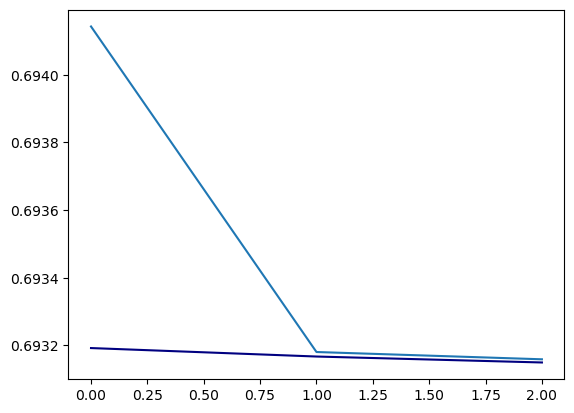

In [8]:
plt.plot([mt["loss"] for mt in my_trial_now], label="Train loss", color="C0")
plt.plot([mt["val_loss"] for mt in my_trial_now], label="Val loss", color="navy")

In [9]:
onco_adj = []
onco_dir = ["../Data/data_STRING/coexpr_vir/onco/"+v for v in os.listdir("../Data/data_STRING/coexpr_vir/onco/")]

for od in tqdm(onco_dir):
    nodes = np.unique(np.concatenate([pd.read_csv(od+"/edges.csv")["source"],pd.read_csv(od+"/edges.csv")["target"]]))
    
    human_ppi = pd.read_csv("../Data/data_STRING/coexpr.edges", sep=" ")
    #human PPI connections with respective identificative index
    human_nodes = pd.read_csv("../Data/data_STRING/coexpr.nodes", sep=" ")

    human_g = gt.Graph(directed=False)
    human_g.add_edge_list(human_ppi.values)
    
    human_map = dict(zip(human_nodes['Prot'], human_nodes['ID']))

    first_neigh_nodes = np.array(itemgetter(*nodes)(human_map))

    # create edge property
    eprop = human_g.new_edge_property("bool")
    eprop.a = np.any([np.isin(human_g.get_edges()[:,0], first_neigh_nodes),np.isin(human_g.get_edges()[:,1], first_neigh_nodes)], axis=0)

    # create a view of a graph and hide all the vertices not in the mask
    gw = gt.GraphView(human_g, efilt=eprop)
    # then create a new graph in which the hidden nodes are pruned
    gf = gt.Graph(gw, prune=True)

    onco_adj.append(torch.from_numpy(gt.spectral.adjacency(gf).toarray()).type(torch.FloatTensor).unsqueeze(0))

100%|█████████████████████████████████████████████| 8/8 [00:02<00:00,  3.11it/s]


In [10]:
nonco_adj = []
nonco_dir = ["../Data/data_STRING/coexpr_vir/nonco/"+v for v in os.listdir("../Data/data_STRING/coexpr_vir/nonco/")]

for od in tqdm(nonco_dir):
    nodes = np.unique(np.concatenate([pd.read_csv(od+"/edges.csv")["source"],pd.read_csv(od+"/edges.csv")["target"]]))
    if len(nodes)>0:
        human_ppi = pd.read_csv("../Data/data_STRING/coexpr.edges", sep=" ")
        #human PPI connections with respective identificative index
        human_nodes = pd.read_csv("../Data/data_STRING/coexpr.nodes", sep=" ")

        human_g = gt.Graph(directed=False)
        human_g.add_edge_list(human_ppi.values)

        human_map = dict(zip(human_nodes['Prot'], human_nodes['ID']))

        first_neigh_nodes = np.array(itemgetter(*nodes)(human_map))

        # create edge property
        eprop = human_g.new_edge_property("bool")
        eprop.a = np.any([np.isin(human_g.get_edges()[:,0], first_neigh_nodes),np.isin(human_g.get_edges()[:,1], first_neigh_nodes)], axis=0)

        # create a view of a graph and hide all the vertices not in the mask
        gw = gt.GraphView(human_g, efilt=eprop)
        # then create a new graph in which the hidden nodes are pruned
        gf = gt.Graph(gw, prune=True)

        nonco_adj.append(torch.from_numpy(gt.spectral.adjacency(gf).toarray()).type(torch.FloatTensor).unsqueeze(0))

100%|███████████████████████████████████████████| 62/62 [00:09<00:00,  6.45it/s]


In [11]:
np.mean([np.mean(na.numpy()) for na in nonco_adj])

0.0013104446

In [12]:
onco_res = []
for i in range(len(onco_adj)):
    with torch.no_grad():
        onco_res.append(trial_now.state["model"].encoder.forward(onco_adj[i].unsqueeze(0))[0].detach().numpy())

In [13]:
nonco_res = []
for i in range(len(nonco_adj)):
    with torch.no_grad():
        nonco_res.append(trial_now.state["model"].encoder.forward(nonco_adj[i].unsqueeze(0))[0].detach().numpy())

In [14]:
import umap

In [32]:
reducer = umap.UMAP(random_state=47)
data_all = np.concatenate([nonco_res, onco_res])
embedding = reducer.fit_transform(data_all)


In [33]:
len(onco_res)

8

In [34]:
colors = (["red"]*len(nonco_res))+(["navy"]*len(onco_res))

In [35]:
np.where(embedding[:,1]<0)

(array([ 0,  2,  4, 14, 16, 20, 24, 25, 26, 30, 31, 33, 34, 36, 37, 39, 41,
        42, 44, 47, 50, 52, 54, 55, 57, 60, 62, 63, 64, 65, 66, 67, 68, 69]),)

In [36]:
labels = np.concatenate([os.listdir("../Data/data_STRING/coexpr_vir/nonco/"),os.listdir("../Data/data_STRING/coexpr_vir/onco/")])

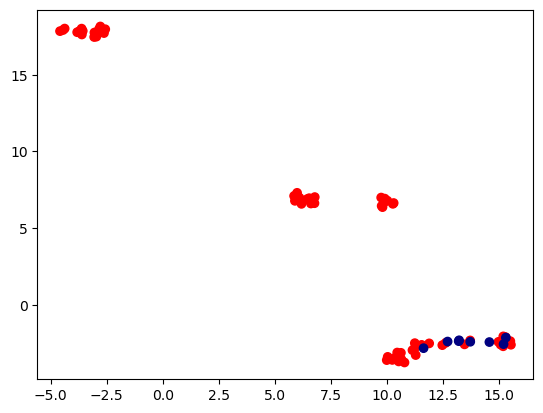

In [37]:
plt.scatter(embedding[:,0],embedding[:,1], color=colors)

In [26]:
import scipy as sp

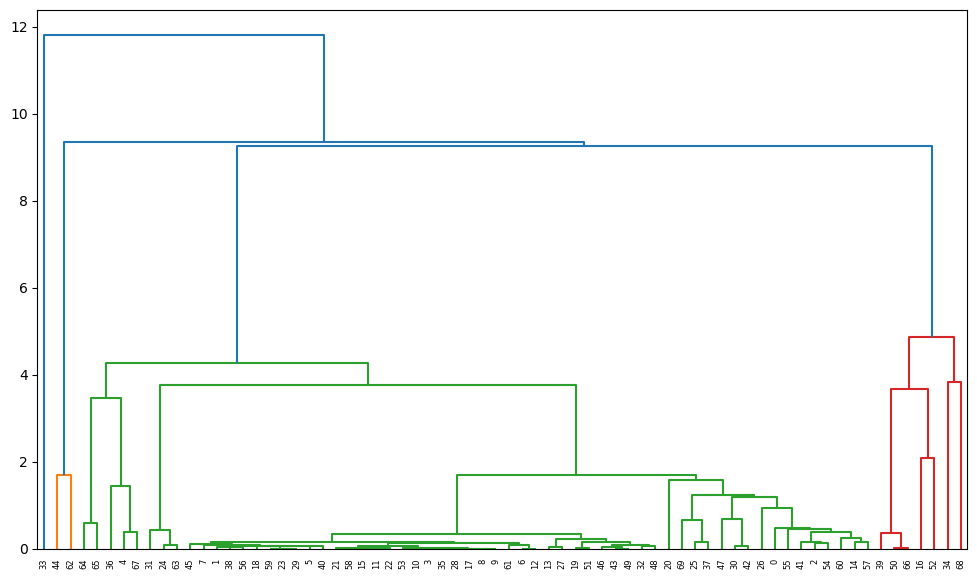

In [31]:
plt.figure(figsize=(12,7))
Z=sp.cluster.hierarchy.linkage(data_all)
dend = sp.cluster.hierarchy.dendrogram(Z)
plt.tick_params(axis="x", color="r")
plt.show()

AttributeError: QuadMesh.set() got an unexpected keyword argument 'set_ytick'

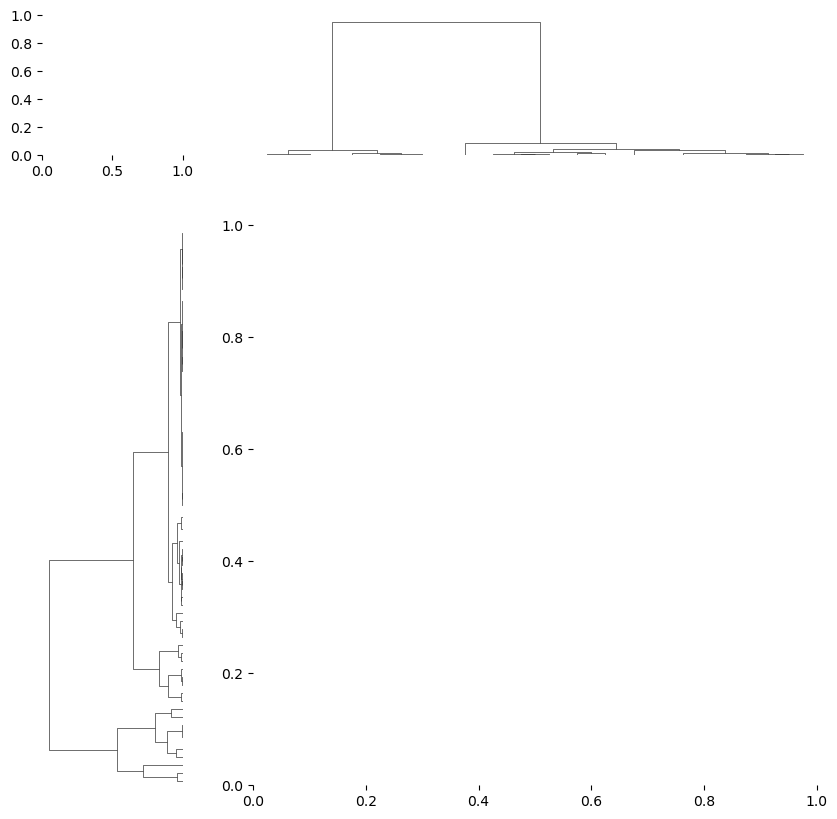

In [42]:
sns.clustermap(data_all, set_ytick=np.arange(len(data_all)))
#plt.yticks()
plt.show()